# Learning objectives

In this Exercise, we will see : 

- An end to end segmentation workflow for 2D classification

Adapted from : https://github.com/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb

# Installing dependencies

The following cell tries to import MONAI and will install its dependencies if needed in the NoteBook environment.

In [1]:
#@formatter:off
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==1.2.0"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
#@formatter:on

# Verify your Configuration

Execute the following cell to check MONAI's configuration using MONAI's `print_config()`.

In [2]:
from monai.config import print_config

print_config()

MONAI version: 1.2.0
Numpy version: 1.26.1
Pytorch version: 2.1.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: C:\Work\Projects\2023_10_19_Formation_Medical_AI_EPITA\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.22.0
Pillow version: 10.1.0
Tensorboard version: 2.14.1
gdown version: 4.7.1
TorchVision version: 0.16.0+cpu
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.6
pandas version: 2.1.1
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.7.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies


# Setup the MedNIST directory

In this exercise, we will be using the MedNIST dataset

In [3]:
from monai.utils import set_determinism
from monai.apps import download_and_extract
from pathlib import Path

set_determinism(seed=0)
directory = "./Data/MedNIST"
Path(directory).mkdir(exist_ok=True)

resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = Path(directory, "MedNIST.tar.gz")
data_dir = Path(directory, "MedNIST")
if not data_dir.exists():
    download_and_extract(resource, compressed_file, directory, md5)

MedNIST.tar.gz: 59.0MB [00:02, 29.0MB/s]                              


2023-11-02 09:29:44,755 - INFO - Downloaded: Data\MedNIST\MedNIST.tar.gz
2023-11-02 09:29:44,845 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-11-02 09:29:44,846 - INFO - Writing into directory: ./Data/MedNIST.


# Read image filenames from the dataset folders

There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,
Each folder gives the label of the classification model
  

In [5]:
import os
from monai.transforms import LoadImage

class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, classname, x) for x in os.listdir(os.path.join(data_dir, classname))]
    for classname in class_names
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = LoadImage(image_only=True)(image_files_list[0]).shape

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


# Visualize images in the dataset

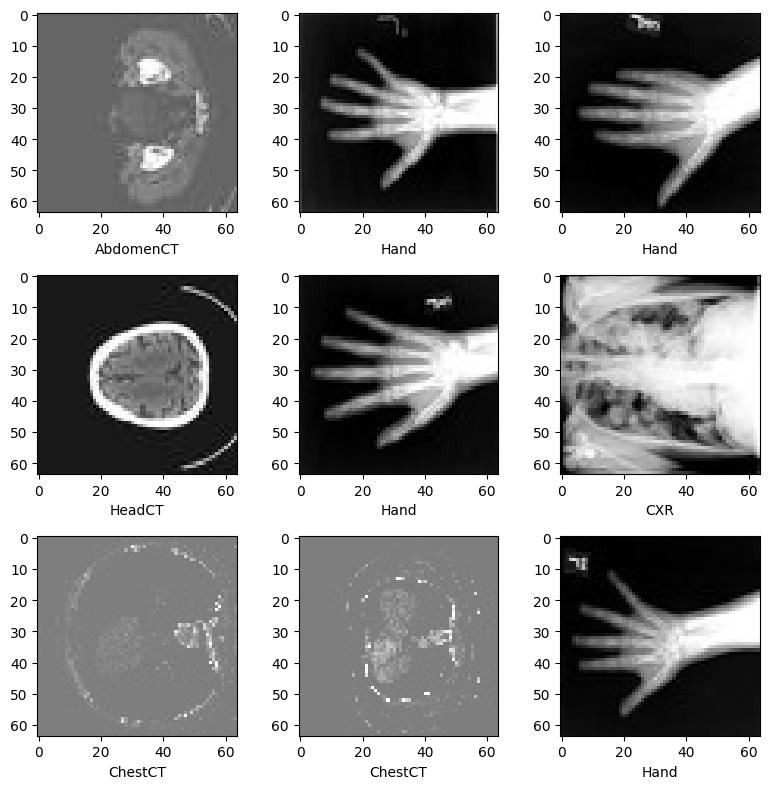

In [6]:
from matplotlib import pyplot as plt
import numpy as np

plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = LoadImage(image_only=True)(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test.

In [7]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


# Define MONAI transforms, Dataset and Dataloader to pre-process data

In [9]:
from monai.transforms import Compose, EnsureChannelFirst, ScaleIntensity, RandRotate, RandFlip, RandZoom, AsDiscrete, \
    Activations

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

# Import MedNIST Dataset

In [11]:
import torch
from monai.data import DataLoader


class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


num_workers = 0
train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=num_workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=num_workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=num_workers)

# Define network and optimizer

In [12]:
from monai.networks.nets import DenseNet121
from monai.metrics import ROCAUCMetric

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

# Model training

In [14]:
from monai.data import decollate_batch

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(directory, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/157, train_loss: 1.1402
2/157, train_loss: 1.1132
3/157, train_loss: 1.1319
4/157, train_loss: 1.0924
5/157, train_loss: 1.0709
6/157, train_loss: 1.1070
7/157, train_loss: 1.0440
8/157, train_loss: 1.0013
9/157, train_loss: 1.0434
10/157, train_loss: 1.0221
11/157, train_loss: 0.9734
12/157, train_loss: 0.9779
13/157, train_loss: 0.9554
14/157, train_loss: 0.9770
15/157, train_loss: 0.9126
16/157, train_loss: 0.9324
17/157, train_loss: 0.9355
18/157, train_loss: 0.8915
19/157, train_loss: 0.9090
20/157, train_loss: 0.8731
21/157, train_loss: 0.8569
22/157, train_loss: 0.8449
23/157, train_loss: 0.8441
24/157, train_loss: 0.8473
25/157, train_loss: 0.8099
26/157, train_loss: 0.8082
27/157, train_loss: 0.8200
28/157, train_loss: 0.7903
29/157, train_loss: 0.7889
30/157, train_loss: 0.7844
31/157, train_loss: 0.7439
32/157, train_loss: 0.7363
33/157, train_loss: 0.7388
34/157, train_loss: 0.7033
35/157, train_loss: 0.7027
36/157, train_loss: 0.7150
37/157, train_lo

# Plot the loss and metric

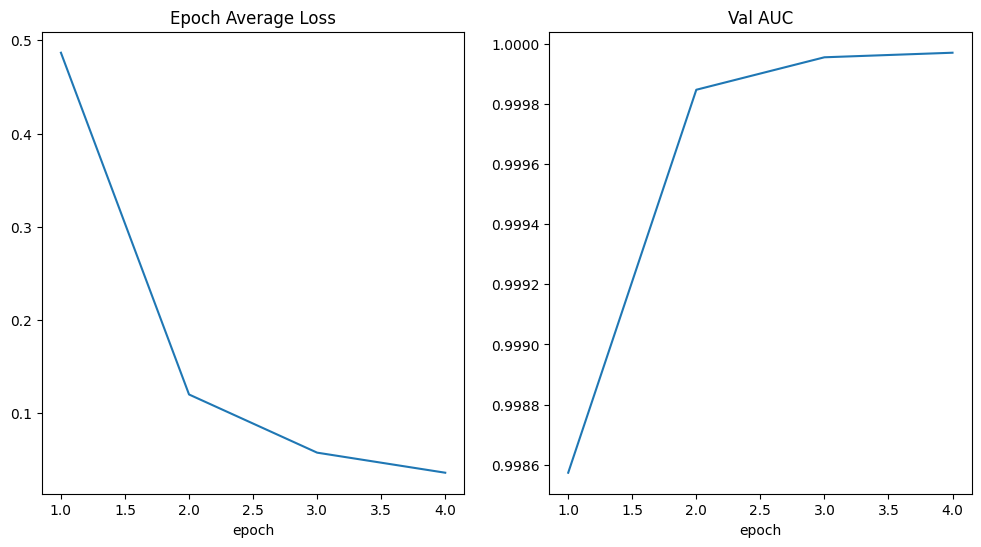

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Evaluate the model on test dataset

In [16]:
model.load_state_dict(torch.load(os.path.join(directory, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9881    0.9990    0.9935       995
   BreastMRI     0.9954    0.9886    0.9920       880
         CXR     0.9990    0.9969    0.9980       982
     ChestCT     0.9980    1.0000    0.9990      1014
        Hand     0.9981    0.9943    0.9962      1048
      HeadCT     0.9990    0.9980    0.9985       976

    accuracy                         0.9963      5895
   macro avg     0.9963    0.9961    0.9962      5895
weighted avg     0.9963    0.9963    0.9963      5895


# Confusion matrix

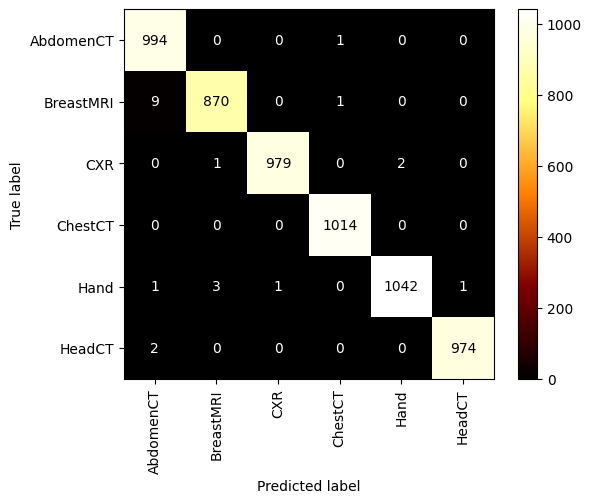

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=class_names,
    xticks_rotation="vertical",
    cmap="afmhot"
)

# Activation map and occlusion sensitivity

100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


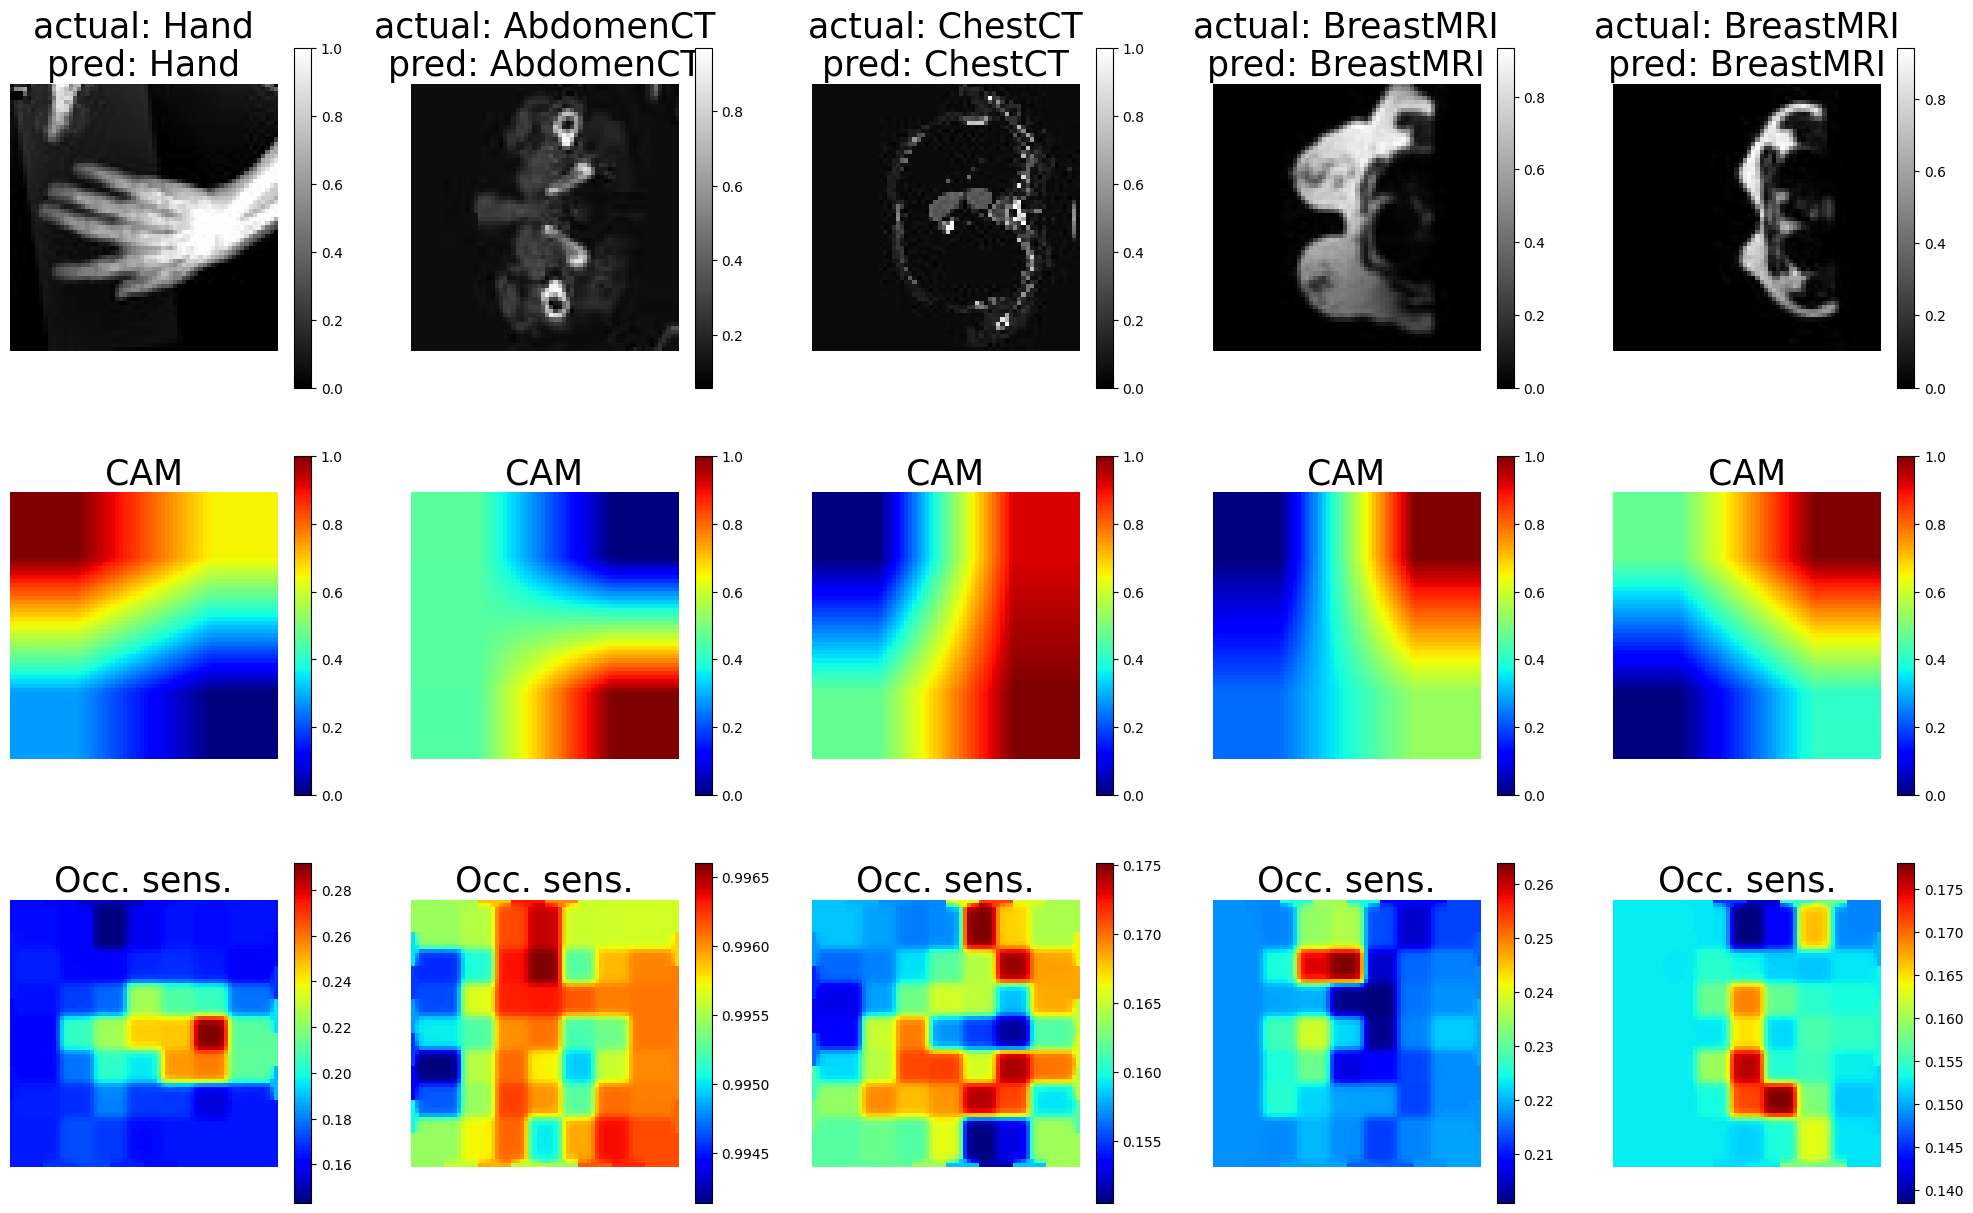

In [19]:
from monai.visualize import GradCAMpp, OcclusionSensitivity

cam = GradCAMpp(nn_module=model, target_layers="class_layers.relu")
occ_sens = OcclusionSensitivity(nn_module=model, overlap=0.5, n_batch=300)

n_examples = 5
subplot_shape = [3, n_examples]
fig, axes = plt.subplots(*subplot_shape, figsize=(25, 15), facecolor="white")
items = np.random.choice(len(train_ds), size=len(train_ds), replace=False)

example = 0
for item in items:
    data = train_ds[item]  # this fetches training data with random augmentations
    image, label = data[0].to(device).unsqueeze(0), data[1]
    y_pred = model(image)
    pred_label = y_pred.argmax(1).item()

    img = image.detach().cpu().numpy()

    name = f"actual: {class_names[label]}\npred: {class_names[pred_label]}"

    # run CAM
    cam_result = cam(x=image, class_idx=pred_label)

    # run occlusion
    occ_result, _ = occ_sens(x=image)

    for row, (im, title) in enumerate(
            zip(
                [img, cam_result, occ_result],
                [name, "CAM", "Occ. sens."],
            )
    ):
        cmap = "gray" if row == 0 else "jet"
        ax = axes[row, example]
        if isinstance(im, torch.Tensor):
            im = im.cpu().detach()
        im_show = ax.imshow(im[0][0], cmap=cmap)

        ax.set_title(title, fontsize=25)
        ax.axis("off")
        fig.colorbar(im_show, ax=ax)

    example += 1
    if example == n_examples:
        break